# Find Alpha Attribute from Sepsis dataset. clustering/classification

### Reading data

In [26]:
import os
import pm4py
from pm4py.objects.log.importer.xes import importer as xes_importer
import warnings
warnings.simplefilter("ignore")
from pm4py.objects.log.log import EventLog
# from ClusterFlags import bag_of_activities
from pm4py.objects.log.util import get_log_representation as get_
from sklearn.decomposition import PCA
from pm4py.objects.log.obj import EventLog, Trace
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import numpy as np

### Filtered data = Complete traces - Ending in Release

In [27]:
import pandas as pd
sepsis = pd.read_csv('Datasets/Sepsis Cases - Event Log -Filtered.csv')
sepsis.head()

,Case ID,Activity,Complete Timestamp,Variant,Variant index,lifecycle:transition,org:group,InfectionSuspected,DiagnosticBlood,DisfuncOrg,...,SIRSCritLeucos,Oligurie,DiagnosticLacticAcid,Diagnose,Hypoxie,DiagnosticUrinarySediment,DiagnosticECG,Leucocytes,CRP,LacticAcid
0,A,ER Registration,2014-10-22 11:15:41.000,Variant 35,35,complete,A,True,True,True,...,False,False,True,A,False,True,True,NaN,NaN,NaN
1,A,Leucocytes,2014-10-22 11:27:00.000,Variant 35,35,complete,B,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.6,NaN,NaN
2,A,CRP,2014-10-22 11:27:00.000,Variant 35,35,complete,B,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,NaN
3,A,LacticAcid,2014-10-22 11:27:00.000,Variant 35,35,complete,B,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.2
4,A,ER Triage,2014-10-22 11:33:37.000,Variant 35,35,complete,C,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Getting Release Type of every case

In [28]:
rel = sepsis[['Case ID', 'Activity']]
release = rel[rel['Activity'].str.contains('Release')]

### Counting number of activities

In [29]:
count_events = sepsis[['Case ID','Activity','Leucocytes', 'CRP', 'LacticAcid']]
count_events_and_tests= count_events.groupby('Case ID')[['Activity','Leucocytes', 'CRP', 'LacticAcid']].count()
count_events_and_tests.head()


,Activity,Leucocytes,CRP,LacticAcid
Case ID,,,,
A,22,7,7,1
AAA,11,1,1,1
ABA,17,5,4,1
AC,13,2,2,1
AD,29,7,7,5


### Dropping non important features.

In [30]:
sepsis = sepsis.drop(['Activity', 'Complete Timestamp', 'Variant', 'Variant index',
    'lifecycle:transition', 'org:group'], axis=1)
sepsis.head(20)

,Case ID,InfectionSuspected,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,Hypotensie,SIRSCritHeartRate,Infusion,DiagnosticArtAstrup,Age,...,SIRSCritLeucos,Oligurie,DiagnosticLacticAcid,Diagnose,Hypoxie,DiagnosticUrinarySediment,DiagnosticECG,Leucocytes,CRP,LacticAcid
0,A,True,True,True,True,True,True,True,True,85.0,...,False,False,True,A,False,True,True,NaN,NaN,NaN
1,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.6,NaN,NaN
2,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.0,NaN
3,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.2
4,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,109.0,NaN


### Dropping rows with NAN values i.e. keeping 1 row for each case

In [31]:
sep=sepsis.dropna(thresh=15)
sep.reset_index(drop=True, inplace=True)
sep.shape

(777, 28)

In [32]:
len(sepsis.Diagnose.unique())


142

In [33]:
count_events_and_tests =count_events_and_tests.reset_index()

In [50]:
count_events_and_tests = count_events_and_tests[['Case ID','Activity_count']]

### Dropping Numeric tests counts

In [52]:
count_events_and_tests

,Case ID,Activity_count
0,A,22
1,AAA,11
2,ABA,17
3,AC,13
4,AD,29
...,...,...
771,ZU,10
772,ZV,12
773,ZW,13
774,ZX,10


In [53]:
# Renaming Column names of dataframe of Counts
count_events_and_tests.rename(columns={'Activity': 'Activity_count', 'Leucocytes': 'Leucocytes_count','CRP':'CRP_count','LacticAcid':'LacticAcid_count'}, inplace=True)
release.rename(columns={'Activity': 'Release_type'}, inplace=True)

### Dropping Tests from sepsis dataset

In [54]:
sep = sep.drop(['Leucocytes', 'CRP', 'LacticAcid'], axis=1)
sep.head()

KeyError: "['Leucocytes', 'CRP', 'LacticAcid'] not found in axis"

### Merging All dataframes to constitute table with additional columns i.e. Count of activities and Tests conducted

In [55]:
mer =pd.merge(count_events_and_tests, release, on='Case ID', how='outer')
mer.shape

(777, 3)

In [56]:
mer

,Case ID,Activity_count,Release_type
0,A,22.0,Release A
1,AAA,11.0,Release A
2,ABA,17.0,Release A
3,AC,13.0,Release A
4,AD,29.0,Release A
...,...,...,...
772,ZV,12.0,Release A
773,ZW,13.0,Release A
774,ZX,10.0,Release A
775,ZZ,14.0,Release A


In [57]:
processed_data = pd.merge(sep, mer, on='Case ID', how='outer')
processed_data.head(10)

,Case ID,InfectionSuspected,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,Hypotensie,SIRSCritHeartRate,Infusion,DiagnosticArtAstrup,Age,...,DiagnosticUrinaryCulture,SIRSCritLeucos,Oligurie,DiagnosticLacticAcid,Diagnose,Hypoxie,DiagnosticUrinarySediment,DiagnosticECG,Activity_count,Release_type
0,A,True,True,True,True,True,True,True,True,85.0,...,True,False,False,True,A,False,True,True,22.0,Release A
1,B,True,True,False,True,False,True,True,False,45.0,...,True,False,False,True,B,False,True,True,12.0,Release A
2,C,True,True,False,False,False,True,True,True,55.0,...,True,False,False,True,C,False,True,True,14.0,Release A
3,D,True,True,False,True,False,True,True,True,70.0,...,False,False,False,True,D,False,False,True,13.0,Release A
4,F,True,True,False,False,False,True,True,False,50.0,...,False,False,False,True,E,False,False,True,10.0,Release A
5,G,True,True,False,False,False,True,True,False,60.0,...,True,False,False,True,F,False,True,True,12.0,Release A
6,H,False,False,False,True,False,True,False,False,80.0,...,False,False,False,False,G,False,False,False,13.0,Release B
7,I,True,True,False,False,False,True,False,True,80.0,...,True,False,False,True,H,False,True,True,11.0,Release A
8,J,True,True,False,True,False,True,True,False,80.0,...,False,False,False,True,B,False,True,True,11.0,Release A
9,K,True,True,False,True,False,True,True,False,50.0,...,True,False,False,True,I,False,True,True,16.0,Release A


### Data Cleaning

In [58]:
processed_data.isna().sum()

Case ID                       1
InfectionSuspected            0
DiagnosticBlood               0
DisfuncOrg                    0
SIRSCritTachypnea             0
Hypotensie                    0
SIRSCritHeartRate             0
Infusion                      0
DiagnosticArtAstrup           0
Age                          43
DiagnosticIC                  0
DiagnosticSputum              0
DiagnosticLiquor              0
DiagnosticOther               0
SIRSCriteria2OrMore           0
DiagnosticXthorax             0
SIRSCritTemperature           0
DiagnosticUrinaryCulture      0
SIRSCritLeucos                0
Oligurie                      0
DiagnosticLacticAcid          0
Diagnose                     47
Hypoxie                       0
DiagnosticUrinarySediment     0
DiagnosticECG                 0
Activity_count                1
Release_type                  0
dtype: int64

In [59]:
# Deleting Case with null case id, Dropping rows with Age and Diagnosis null.
df = processed_data[processed_data['Case ID'].notna()]
df = df[df['Diagnose'].notna()]

In [60]:
df.isna().sum()

Case ID                      0
InfectionSuspected           0
DiagnosticBlood              0
DisfuncOrg                   0
SIRSCritTachypnea            0
Hypotensie                   0
SIRSCritHeartRate            0
Infusion                     0
DiagnosticArtAstrup          0
Age                          0
DiagnosticIC                 0
DiagnosticSputum             0
DiagnosticLiquor             0
DiagnosticOther              0
SIRSCriteria2OrMore          0
DiagnosticXthorax            0
SIRSCritTemperature          0
DiagnosticUrinaryCulture     0
SIRSCritLeucos               0
Oligurie                     0
DiagnosticLacticAcid         0
Diagnose                     0
Hypoxie                      0
DiagnosticUrinarySediment    0
DiagnosticECG                0
Activity_count               0
Release_type                 0
dtype: int64

In [61]:
df.head()

,Case ID,InfectionSuspected,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,Hypotensie,SIRSCritHeartRate,Infusion,DiagnosticArtAstrup,Age,...,DiagnosticUrinaryCulture,SIRSCritLeucos,Oligurie,DiagnosticLacticAcid,Diagnose,Hypoxie,DiagnosticUrinarySediment,DiagnosticECG,Activity_count,Release_type
0,A,True,True,True,True,True,True,True,True,85.0,...,True,False,False,True,A,False,True,True,22.0,Release A
1,B,True,True,False,True,False,True,True,False,45.0,...,True,False,False,True,B,False,True,True,12.0,Release A
2,C,True,True,False,False,False,True,True,True,55.0,...,True,False,False,True,C,False,True,True,14.0,Release A
3,D,True,True,False,True,False,True,True,True,70.0,...,False,False,False,True,D,False,False,True,13.0,Release A
4,F,True,True,False,False,False,True,True,False,50.0,...,False,False,False,True,E,False,False,True,10.0,Release A


In [62]:
print(df.describe())

              Age  Activity_count
count  729.000000      729.000000
mean    71.995885       16.954733
std     15.525192       12.009240
min     20.000000        5.000000
25%     65.000000       12.000000
50%     75.000000       14.000000
75%     85.000000       18.000000
max     90.000000      185.000000


In [63]:
# Converting True and False in to 1 and 0
df.replace({False: 0, True: 1}, inplace=True)
df.head()

,Case ID,InfectionSuspected,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,Hypotensie,SIRSCritHeartRate,Infusion,DiagnosticArtAstrup,Age,...,DiagnosticUrinaryCulture,SIRSCritLeucos,Oligurie,DiagnosticLacticAcid,Diagnose,Hypoxie,DiagnosticUrinarySediment,DiagnosticECG,Activity_count,Release_type
0,A,1,1,1,1,1,1,1,1,85.0,...,1,0,0,1,A,0,1,1,22.0,Release A
1,B,1,1,0,1,0,1,1,0,45.0,...,1,0,0,1,B,0,1,1,12.0,Release A
2,C,1,1,0,0,0,1,1,1,55.0,...,1,0,0,1,C,0,1,1,14.0,Release A
3,D,1,1,0,1,0,1,1,1,70.0,...,0,0,0,1,D,0,0,1,13.0,Release A
4,F,1,1,0,0,0,1,1,0,50.0,...,0,0,0,1,E,0,0,1,10.0,Release A


In [64]:
df.select_dtypes(include=['object'])

,Case ID,Diagnose,Release_type
0,A,A,Release A
1,B,B,Release A
2,C,C,Release A
3,D,D,Release A
4,F,E,Release A
...,...,...,...
772,BNA,Z,Release A
773,CNA,BA,Release A
774,GNA,G,Release A
775,HNA,G,Release A


In [65]:
# Encoding Diagnose and Release Type categorical features
df[['Diagnose', 'Release_type']] = df[['Diagnose', 'Release_type']].apply(lambda x: pd.factorize(x)[0])
df.head()

,Case ID,InfectionSuspected,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,Hypotensie,SIRSCritHeartRate,Infusion,DiagnosticArtAstrup,Age,...,DiagnosticUrinaryCulture,SIRSCritLeucos,Oligurie,DiagnosticLacticAcid,Diagnose,Hypoxie,DiagnosticUrinarySediment,DiagnosticECG,Activity_count,Release_type
0,A,1,1,1,1,1,1,1,1,85.0,...,1,0,0,1,0,0,1,1,22.0,0
1,B,1,1,0,1,0,1,1,0,45.0,...,1,0,0,1,1,0,1,1,12.0,0
2,C,1,1,0,0,0,1,1,1,55.0,...,1,0,0,1,2,0,1,1,14.0,0
3,D,1,1,0,1,0,1,1,1,70.0,...,0,0,0,1,3,0,0,1,13.0,0
4,F,1,1,0,0,0,1,1,0,50.0,...,0,0,0,1,4,0,0,1,10.0,0


In [66]:
df.shape

(729, 27)

In [67]:
df.to_csv('Datasets/Processed_cleaned_data.csv')

# Clustering 

## Clustering on Descriptive Features

In [23]:
df = pd.read_csv('Datasets/Processed_cleaned_data.csv')
df.shape

(729, 31)

In [68]:
descriptive_features = df.drop(['Case ID'],axis=1)
descriptive_features.head()

,InfectionSuspected,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,Hypotensie,SIRSCritHeartRate,Infusion,DiagnosticArtAstrup,Age,DiagnosticIC,...,DiagnosticUrinaryCulture,SIRSCritLeucos,Oligurie,DiagnosticLacticAcid,Diagnose,Hypoxie,DiagnosticUrinarySediment,DiagnosticECG,Activity_count,Release_type
0,1,1,1,1,1,1,1,1,85.0,1,...,1,0,0,1,0,0,1,1,22.0,0
1,1,1,0,1,0,1,1,0,45.0,1,...,1,0,0,1,1,0,1,1,12.0,0
2,1,1,0,0,0,1,1,1,55.0,1,...,1,0,0,1,2,0,1,1,14.0,0
3,1,1,0,1,0,1,1,1,70.0,1,...,0,0,0,1,3,0,0,1,13.0,0
4,1,1,0,0,0,1,1,0,50.0,1,...,0,0,0,1,4,0,0,1,10.0,0


##  Elbow Method to extract optimal number of clusters

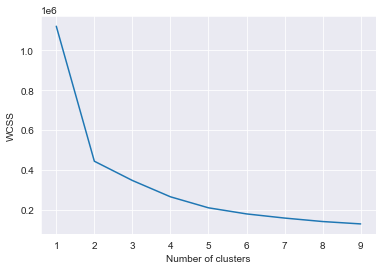

In [93]:

from sklearn.cluster import KMeans
within_cluster_sum_of_squares = []

for i in range(1, 10):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
    kmeans.fit(descriptive_features)
    within_cluster_sum_of_squares.append(kmeans.inertia_)
    
#Plotting the results onto a line graph, allowing us to observe 'The elbow'
plt.plot(range(1, 10), within_cluster_sum_of_squares)

plt.xlabel('Number of clusters')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

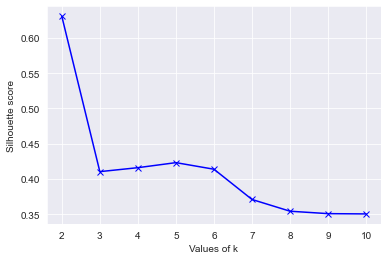

In [96]:
range_n_clusters = [ 2, 3, 4, 5, 6, 7, 8,9,10]
silhouette_avg = []
for num_clusters in range_n_clusters:
 
 # initialise kmeans
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(descriptive_features)
 cluster_labels = kmeans.labels_
 
 # silhouette score
 silhouette_avg.append(silhouette_score(descriptive_features, cluster_labels))
plt.plot(range_n_clusters,silhouette_avg,"bx-")
plt.xlabel("Values of k") 
plt.ylabel("Silhouette score") 
plt.show()

## Keeping filtered cases in the main event log

In [77]:

el = pd.read_csv('Datasets/Sepsis Cases - Event Log.csv')
cases = df['Case ID']
el = el.loc[el['Case ID'].isin(cases)] 
el.shape

(12360, 34)

In [78]:

dataframe = pm4py.format_dataframe(el, case_id='Case ID', activity_key='Activity', timestamp_key='Complete Timestamp')
event_log = pm4py.convert_to_event_log(dataframe)

k means Clustering

In [74]:

kmeans = KMeans(
        init="random",
        n_clusters=2,
        n_init=10,
        max_iter=300,
        random_state=42
    )
km = kmeans.fit(descriptive_features)




In [80]:
already_seen = {}
labels = km.labels_
clusters = []

for i in range(len(event_log)):
        if not labels[i] in already_seen:
            already_seen[labels[i]] = len(list(already_seen.keys()))
            clusters.append(EventLog())
        trace = event_log[i]
        clusters[already_seen[labels[i]]].append(trace)

type(clusters[0]),len(clusters[0]),len(clusters[1])

(pm4py.objects.log.obj.EventLog, 581, 148)

## Clustering  on Normailsed Descriptive Features

### Normalise dataframe

In [88]:

from sklearn import preprocessing

x = descriptive_features.values 
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
descriptive_features_normailsed = pd.DataFrame(x_scaled)
descriptive_features_normailsed.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.928571,1.0,...,1.0,0.0,0.0,1.0,0.000000,0.0,1.0,1.0,0.094444,0.0
1,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.357143,1.0,...,1.0,0.0,0.0,1.0,0.007299,0.0,1.0,1.0,0.038889,0.0
2,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.500000,1.0,...,1.0,0.0,0.0,1.0,0.014599,0.0,1.0,1.0,0.050000,0.0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.714286,1.0,...,0.0,0.0,0.0,1.0,0.021898,0.0,0.0,1.0,0.044444,0.0
4,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.428571,1.0,...,0.0,0.0,0.0,1.0,0.029197,0.0,0.0,1.0,0.027778,0.0


##  Elbow Method to extract optimal number of clusters

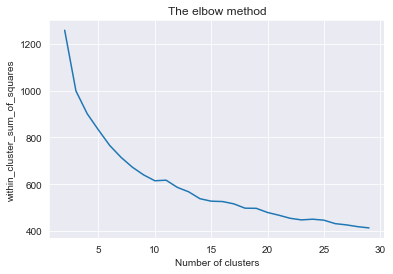

In [97]:

from sklearn.cluster import KMeans
within_cluster_sum_of_squares = []

for i in range(2, 30):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 42)
    kmeans.fit(descriptive_features_normailsed)
    within_cluster_sum_of_squares.append(kmeans.inertia_)
    
#Plotting the results onto a line graph, allowing us to observe 'The elbow'
plt.plot(range(2, 30), within_cluster_sum_of_squares)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('within_cluster_sum_of_squares') #within cluster sum of squares
plt.show()


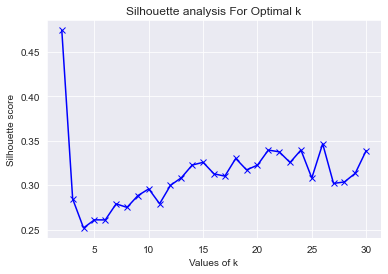

In [98]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30]
silhouette_avg = []
for num_clusters in range_n_clusters:
 
 # initialise kmeans
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(descriptive_features_normailsed)
 cluster_labels = kmeans.labels_
 
 # silhouette score
 silhouette_avg.append(silhouette_score(descriptive_features_normailsed, cluster_labels))
plt.plot(range_n_clusters,silhouette_avg,"bx-")
plt.xlabel("Values of k") 
plt.ylabel("Silhouette score") 
plt.title("Silhouette analysis For Optimal k")
plt.show()

In [90]:

kmeans = KMeans(
        init="random",
        n_clusters=3,
        n_init=10,
        max_iter=300,
        random_state=42
    )
km = kmeans.fit(descriptive_features_normailsed)




In [81]:
already_seen = {}
labels = km.labels_
clusters = []

for i in range(len(event_log)):
        if not labels[i] in already_seen:
            already_seen[labels[i]] = len(list(already_seen.keys()))
            clusters.append(EventLog())
        trace = event_log[i]
        clusters[already_seen[labels[i]]].append(trace)

type(clusters[0]),len(clusters[0]),len(clusters[1]),len(clusters[2])

(pm4py.objects.log.obj.EventLog, 410, 238, 81)

In [82]:
sub_log1 = clusters[0]
sub_log2 = clusters[1]
sub_log3 = clusters[2]

pm4py.write_xes(sub_log1, 'Sublogs-Alpha-Clustering-Normalised/sublog1.xes')
pm4py.write_xes(sub_log2, 'Sublogs-Alpha-Clustering-Normalised/sublog2.xes')
pm4py.write_xes(sub_log3, 'Sublogs-Alpha-Clustering-Normalised/sublog3.xes')


exporting log, completed traces :: 100%|██████████| 81/81 [00:01<00:00, 59.90it/s] 


### Finding Important Feature of K means Clustering

In [81]:
from sklearn.cluster import KMeans
import numpy as np


class KMeansInterp(KMeans):
    def __init__(self, ordered_feature_names, feature_importance_method='wcss_min', **kwargs):
        super(KMeansInterp, self).__init__(**kwargs)
        self.feature_importance_method = feature_importance_method
        self.ordered_feature_names = ordered_feature_names
        
    def fit(self, X, y=None, sample_weight=None):
        super().fit(X=X, y=y, sample_weight=sample_weight)
        
        if not len(self.ordered_feature_names) == self.n_features_in_:
            raise Exception(f"Model is fitted on {self.n_features_in_} but ordered_feature_names = {len(self.ordered_feature_names)}")
        
        if self.feature_importance_method == "wcss_min":
            self.feature_importances_ = self.get_feature_imp_wcss_min()
        elif self.feature_importance_method == "unsup2sup":
            self.feature_importances_ = self.get_feature_imp_unsup2sup(X)
        else: 
            raise Exception(f" {self.feature_importance_method}"+\
            "is not available. Please choose from  ['wcss_min' , 'unsup2sup']")
        
        return self
        
    def get_feature_imp_wcss_min(self):
        labels = self.n_clusters
        centroids = self.cluster_centers_
        centroids = np.vectorize(lambda x: np.abs(x))(centroids)
        sorted_centroid_features_idx = centroids.argsort(axis=1)[:,::-1]

        cluster_feature_weights = {}
        for label, centroid in zip(range(labels), sorted_centroid_features_idx):
            ordered_cluster_feature_weights = centroids[label][sorted_centroid_features_idx[label]]
            ordered_cluster_features = [self.ordered_feature_names[feature] for feature in centroid]
            cluster_feature_weights[label] = list(zip(ordered_cluster_features, 
                                                      ordered_cluster_feature_weights))
        
        return cluster_feature_weights
    
    def get_feature_imp_unsup2sup(self, X):
        try:
            from sklearn.ensemble import RandomForestClassifier
        except ImportError as IE:
            print(IE.__class__.__name__ + ": " + IE.message)
            raise Exception("Please install scikit-learn. ")
        
        cluster_feature_weights = {}
        for label in range(self.n_clusters):
            binary_enc = np.vectorize(lambda x: 1 if x == label else 0)(self.labels_)
            clf = RandomForestClassifier()
            clf.fit(X, binary_enc)

            sorted_feature_weight_idxes = np.argsort(clf.feature_importances_)[::-1]
            ordered_cluster_features = np.take_along_axis(
                np.array(self.ordered_feature_names), 
                sorted_feature_weight_idxes, 
                axis=0)
            ordered_cluster_feature_weights = np.take_along_axis(
                np.array(clf.feature_importances_), 
                sorted_feature_weight_idxes, 
                axis=0)
            cluster_feature_weights[label] = list(zip(ordered_cluster_features, 
                                                      ordered_cluster_feature_weights))
        return cluster_feature_weights

In [84]:
descriptive_features = descriptive_features.loc[:, descriptive_features.columns != "Unnamed: 0"]

In [106]:
descriptive_features_normailsed

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.928571,...,1.0,0.000000,0.0,1.0,1.0,0.094444,0.094595,0.101449,0.019608,0.0
1,0.001289,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.357143,...,1.0,0.007299,0.0,1.0,1.0,0.038889,0.013514,0.043478,0.019608,0.0
2,0.002577,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.500000,...,1.0,0.014599,0.0,1.0,1.0,0.050000,0.040541,0.043478,0.000000,0.0
3,0.003866,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.714286,...,1.0,0.021898,0.0,0.0,1.0,0.044444,0.027027,0.028986,0.019608,0.0
4,0.005155,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.428571,...,1.0,0.029197,0.0,0.0,1.0,0.027778,0.013514,0.014493,0.019608,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,0.994845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.142857,...,0.0,0.182482,0.0,0.0,1.0,0.011111,0.013514,0.014493,0.000000,0.0
725,0.996134,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.642857,...,0.0,0.197080,0.0,0.0,0.0,0.066667,0.081081,0.072464,0.000000,0.0
726,0.997423,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.500000,...,1.0,0.043796,0.0,1.0,1.0,0.111111,0.081081,0.072464,0.098039,0.0
727,0.998711,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.785714,...,1.0,0.043796,0.0,1.0,1.0,0.138889,0.108108,0.130435,0.098039,0.0


In [107]:
descriptive_features_normailsed = descriptive_features_normailsed.drop(descriptive_features_normailsed.columns[0], axis=1)


In [108]:
descriptive_features_normailsed

,1,2,3,4,5,6,7,8,9,10,...,20,21,22,23,24,25,26,27,28,29
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.928571,1.0,...,1.0,0.000000,0.0,1.0,1.0,0.094444,0.094595,0.101449,0.019608,0.0
1,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.357143,1.0,...,1.0,0.007299,0.0,1.0,1.0,0.038889,0.013514,0.043478,0.019608,0.0
2,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.500000,1.0,...,1.0,0.014599,0.0,1.0,1.0,0.050000,0.040541,0.043478,0.000000,0.0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.714286,1.0,...,1.0,0.021898,0.0,0.0,1.0,0.044444,0.027027,0.028986,0.019608,0.0
4,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.428571,1.0,...,1.0,0.029197,0.0,0.0,1.0,0.027778,0.013514,0.014493,0.019608,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.142857,1.0,...,0.0,0.182482,0.0,0.0,1.0,0.011111,0.013514,0.014493,0.000000,0.0
725,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.642857,0.0,...,0.0,0.197080,0.0,0.0,0.0,0.066667,0.081081,0.072464,0.000000,0.0
726,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.500000,1.0,...,1.0,0.043796,0.0,1.0,1.0,0.111111,0.081081,0.072464,0.098039,0.0
727,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.785714,1.0,...,1.0,0.043796,0.0,1.0,1.0,0.138889,0.108108,0.130435,0.098039,0.0


In [82]:

kms = KMeansInterp(
	n_clusters=2,
	ordered_feature_names=descriptive_features.columns.tolist(), 
	feature_importance_method='wcss_min', # or 'unsup2sup'
).fit(descriptive_features.values)

# A dictionary where the key [0] is the cluster label, and [:10] will refer to the first 10 most important features
kms.feature_importances_[0][:10] # Features here are words


[('Age', 72.18588640275387),
 ('Activity_count', 16.41652323580034),
 ('Diagnose', 9.42857142857147),
 ('SIRSCriteria2OrMore', 0.9087779690189328),
 ('InfectionSuspected', 0.901893287435456),
 ('DiagnosticIC', 0.8984509466437176),
 ('DiagnosticBlood', 0.8709122203098106),
 ('DiagnosticLacticAcid', 0.8588640275387264),
 ('Infusion', 0.8571428571428571),
 ('SIRSCritHeartRate', 0.8519793459552496)]

In [99]:
features_kms = pd.DataFrame(kms.feature_importances_[0][:10])
features_kms.set_index(0,inplace=True)
features_kms


,1
0,
Age,72.185886
Activity_count,16.416523
Diagnose,9.428571
SIRSCriteria2OrMore,0.908778
InfectionSuspected,0.901893
DiagnosticIC,0.898451
DiagnosticBlood,0.870912
DiagnosticLacticAcid,0.858864
Infusion,0.857143


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Age'),
  Text(1, 0, 'Activity_count'),
  Text(2, 0, 'Diagnose'),
  Text(3, 0, 'SIRSCriteria2OrMore'),
  Text(4, 0, 'InfectionSuspected'),
  Text(5, 0, 'DiagnosticIC'),
  Text(6, 0, 'DiagnosticBlood'),
  Text(7, 0, 'DiagnosticLacticAcid'),
  Text(8, 0, 'Infusion'),
  Text(9, 0, 'SIRSCritHeartRate')])

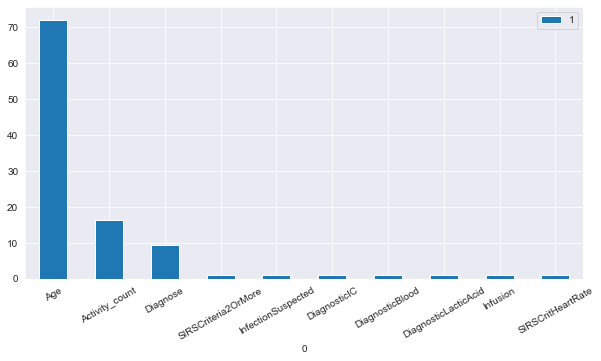

In [100]:
features_kms.plot.bar(figsize=(10,5))
plt.xticks(rotation=30)

In [88]:
descriptive_features

,InfectionSuspected,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,Hypotensie,SIRSCritHeartRate,Infusion,DiagnosticArtAstrup,Age,DiagnosticIC,...,DiagnosticLacticAcid,Diagnose,Hypoxie,DiagnosticUrinarySediment,DiagnosticECG,Activity_count,Leucocytes_count,CRP_count,LacticAcid_count,Release_type
0,1,1,1,1,1,1,1,1,85.0,1,...,1,0,0,1,1,22.0,7.0,7.0,1.0,0
1,1,1,0,1,0,1,1,0,45.0,1,...,1,1,0,1,1,12.0,1.0,3.0,1.0,0
2,1,1,0,0,0,1,1,1,55.0,1,...,1,2,0,1,1,14.0,3.0,3.0,0.0,0
3,1,1,0,1,0,1,1,1,70.0,1,...,1,3,0,0,1,13.0,2.0,2.0,1.0,0
4,1,1,0,0,0,1,1,0,50.0,1,...,1,4,0,0,1,10.0,1.0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,0,0,0,0,0,0,0,1,30.0,1,...,0,25,0,0,1,7.0,1.0,1.0,0.0,0
725,0,0,0,1,0,1,0,0,65.0,0,...,0,27,0,0,0,17.0,6.0,5.0,0.0,0
726,1,1,0,1,0,1,1,0,55.0,1,...,1,6,0,1,1,25.0,6.0,5.0,5.0,0
727,1,1,0,1,0,1,1,1,75.0,1,...,1,6,0,1,1,30.0,8.0,9.0,5.0,0


In [94]:
descriptive_features.shape

(729, 29)

In [90]:
descriptive_features_normailsed.shape

(729, 30)

In [101]:

kms_normalised = KMeansInterp(
	n_clusters=3,
	ordered_feature_names=descriptive_features.columns.tolist(), 
	feature_importance_method='wcss_min', # or 'unsup2sup'
).fit(descriptive_features_normailsed.values)

# A dictionary where the key [0] is the cluster label, and [:10] will refer to the first 10 most important features
kms_normalised.feature_importances_[0][:10] 

[('Age', 0.7645502645502645),
 ('Diagnose', 0.29683698296836986),
 ('SIRSCritHeartRate', 0.1604938271604942),
 ('SIRSCritTachypnea', 0.16049382716049382),
 ('SIRSCritTemperature', 0.12345679012345678),
 ('Release_type', 0.08024691358024694),
 ('SIRSCriteria2OrMore', 0.07407407407407363),
 ('Infusion', 0.06172839506172878),
 ('InfectionSuspected', 0.049382716049383046),
 ('Activity_count', 0.04218106995884774)]

Text(0.5, 0, 'Features')

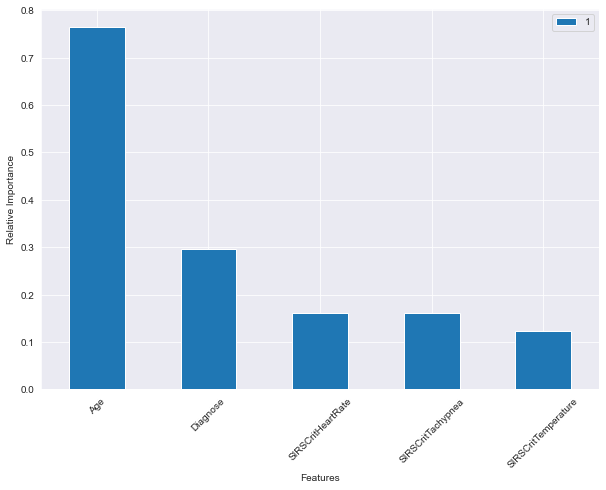

In [107]:
kms_normalised_features = pd.DataFrame(kms_normalised.feature_importances_[0][0:5])
kms_normalised_features.set_index(0,inplace=True)
kms_normalised_features
kms_normalised_features.plot.bar(figsize=(10,7))
plt.xticks(rotation=45)
plt.ylabel("Relative Importance")
plt.xlabel("Features")

## Important Feature - Age 

###  Important Feature - Age 

1. Age - 20-50: 89 Cases
2. 55-65 : 168
3. 70-75 : 181
4. 80-85 : 217
5. 90 : 122

### Important Feature Classification

In [113]:
descriptive_features

,InfectionSuspected,DiagnosticBlood,DisfuncOrg,SIRSCritTachypnea,Hypotensie,SIRSCritHeartRate,Infusion,DiagnosticArtAstrup,Age,DiagnosticIC,...,DiagnosticLacticAcid,Diagnose,Hypoxie,DiagnosticUrinarySediment,DiagnosticECG,Activity_count,Leucocytes_count,CRP_count,LacticAcid_count,Release_type
0,1,1,1,1,1,1,1,1,85.0,1,...,1,0,0,1,1,22.0,7.0,7.0,1.0,0
1,1,1,0,1,0,1,1,0,45.0,1,...,1,1,0,1,1,12.0,1.0,3.0,1.0,0
2,1,1,0,0,0,1,1,1,55.0,1,...,1,2,0,1,1,14.0,3.0,3.0,0.0,0
3,1,1,0,1,0,1,1,1,70.0,1,...,1,3,0,0,1,13.0,2.0,2.0,1.0,0
4,1,1,0,0,0,1,1,0,50.0,1,...,1,4,0,0,1,10.0,1.0,1.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,0,0,0,0,0,0,0,1,30.0,1,...,0,25,0,0,1,7.0,1.0,1.0,0.0,0
725,0,0,0,1,0,1,0,0,65.0,0,...,0,27,0,0,0,17.0,6.0,5.0,0.0,0
726,1,1,0,1,0,1,1,0,55.0,1,...,1,6,0,1,1,25.0,6.0,5.0,5.0,0
727,1,1,0,1,0,1,1,1,75.0,1,...,1,6,0,1,1,30.0,8.0,9.0,5.0,0


### Target feature = Activity_count

In [83]:
target = descriptive_features['Activity_count']
descriptive = descriptive_features.loc[:, descriptive_features.columns != "Activity_count"]
descriptive = descriptive.loc[:, descriptive.columns != "Unnamed: 0"]

In [84]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=0)

# fit the model to the training set

random_forest_classifier.fit(descriptive, target)

# Predict on the test set results

y_pred_100 = random_forest_classifier.predict(descriptive)

# Check accuracy score 

print('Model accuracy score with 100 decision-trees : {0:0.4f}'. format(accuracy_score(target, y_pred_100)))

Model accuracy score with 100 decision-trees : 0.9287


In [85]:
# view the feature scores

feature_scores = pd.Series(random_forest_classifier.feature_importances_, index=descriptive.columns).sort_values(ascending=False)
feature_scores

Diagnose                     0.327253
Age                          0.233084
Release_type                 0.046754
DiagnosticArtAstrup          0.045325
DiagnosticUrinaryCulture     0.042131
SIRSCritTachypnea            0.039548
DiagnosticUrinarySediment    0.038086
SIRSCritTemperature          0.026041
SIRSCritHeartRate            0.025858
DiagnosticECG                0.020745
SIRSCritLeucos               0.016916
DiagnosticXthorax            0.016225
Infusion                     0.016056
DiagnosticLacticAcid         0.014135
DiagnosticSputum             0.014005
Hypotensie                   0.013586
DiagnosticBlood              0.012148
DisfuncOrg                   0.011271
Oligurie                     0.007976
SIRSCriteria2OrMore          0.006681
Hypoxie                      0.006556
InfectionSuspected           0.006350
DiagnosticIC                 0.005449
DiagnosticLiquor             0.004431
DiagnosticOther              0.003393
dtype: float64

In [117]:
type(feature_scores)

pandas.core.series.Series

Text(0.5, 0, 'Features')

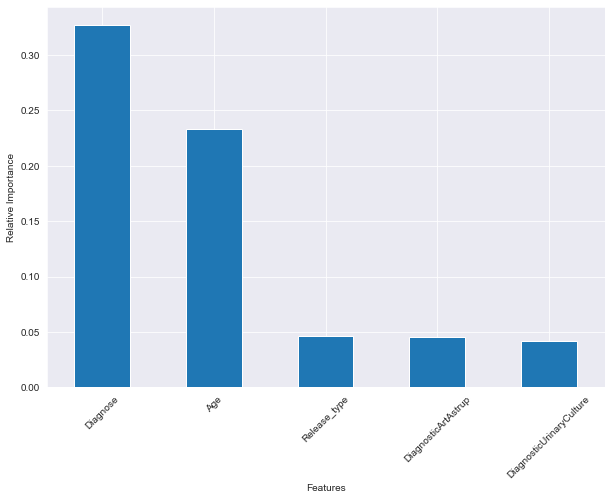

In [106]:
feature_scores.nlargest(5).plot(kind='bar',figsize=(10,7))
plt.xticks(rotation=45)
plt.ylabel("Relative Importance")
plt.xlabel("Features")

(array([], dtype=float64), [])

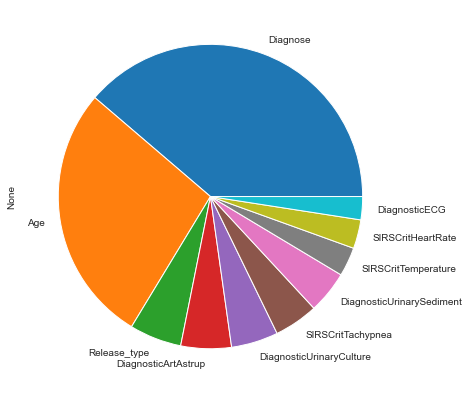

In [108]:
feature_scores.nlargest(10).plot(kind='pie',figsize=(10,7))
plt.xticks(rotation=30)

### Clustering on fitness of sublogs

In [56]:
results = pd.read_excel('results age-10/results age 10.xlsx')
results.head()

,log,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8
0,log_1,0.89,0.86,0.85,0.95,0.80,0.96,0.97,0.97
1,log_2,0.76,0.90,0.90,0.96,0.86,0.91,0.93,0.93
2,log_3,0.76,0.87,0.87,0.92,0.84,0.91,0.93,0.93
3,log_4,0.74,0.87,0.87,0.92,0.83,0.92,0.93,0.93
4,log_5,0.74,0.86,0.86,0.91,0.83,0.90,0.92,0.92


In [57]:
data = results.iloc[:, 1:]
data.head()

,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8
0,0.89,0.86,0.85,0.95,0.80,0.96,0.97,0.97
1,0.76,0.90,0.90,0.96,0.86,0.91,0.93,0.93
2,0.76,0.87,0.87,0.92,0.84,0.91,0.93,0.93
3,0.74,0.87,0.87,0.92,0.83,0.92,0.93,0.93
4,0.74,0.86,0.86,0.91,0.83,0.90,0.92,0.92


In [58]:
data.values

array([[0.89, 0.86, 0.85, 0.95, 0.8 , 0.96, 0.97, 0.97],
       [0.76, 0.9 , 0.9 , 0.96, 0.86, 0.91, 0.93, 0.93],
       [0.76, 0.87, 0.87, 0.92, 0.84, 0.91, 0.93, 0.93],
       [0.74, 0.87, 0.87, 0.92, 0.83, 0.92, 0.93, 0.93],
       [0.74, 0.86, 0.86, 0.91, 0.83, 0.9 , 0.92, 0.92],
       [0.75, 0.88, 0.88, 0.93, 0.85, 0.93, 0.94, 0.95],
       [0.74, 0.88, 0.88, 0.93, 0.85, 0.93, 0.94, 0.94],
       [0.74, 0.86, 0.86, 0.92, 0.84, 0.92, 0.92, 0.94]])

In [59]:
kmeans = KMeans(
        init="random",
        n_clusters=3,
        n_init=5,
        max_iter=500,
        random_state=42
    )
km = kmeans.fit(data.values)

already_seen = {}
labels = km.labels_
labels



array([2, 0, 1, 1, 1, 0, 0, 1], dtype=int32)

### Clustering on Model Fitness

In [60]:
results = pd.read_excel('results age-10/Results age 10 model.xlsx')
results.head()

,log,log_1,log_2,log_3,log_4,log_5,log_6,log_7,log_8
0,model_1,0.89,0.76,0.76,0.74,0.74,0.75,0.74,0.74
1,model_2,0.86,0.90,0.87,0.87,0.86,0.88,0.88,0.86
2,model_3,0.85,0.90,0.87,0.87,0.86,0.88,0.88,0.86
3,model_4,0.95,0.96,0.92,0.92,0.91,0.93,0.93,0.92
4,model_5,0.80,0.86,0.84,0.83,0.83,0.85,0.85,0.84


In [61]:
data = results.iloc[:, 1:]
data.head()

,log_1,log_2,log_3,log_4,log_5,log_6,log_7,log_8
0,0.89,0.76,0.76,0.74,0.74,0.75,0.74,0.74
1,0.86,0.90,0.87,0.87,0.86,0.88,0.88,0.86
2,0.85,0.90,0.87,0.87,0.86,0.88,0.88,0.86
3,0.95,0.96,0.92,0.92,0.91,0.93,0.93,0.92
4,0.80,0.86,0.84,0.83,0.83,0.85,0.85,0.84


In [62]:
data.values

array([[0.89, 0.76, 0.76, 0.74, 0.74, 0.75, 0.74, 0.74],
       [0.86, 0.9 , 0.87, 0.87, 0.86, 0.88, 0.88, 0.86],
       [0.85, 0.9 , 0.87, 0.87, 0.86, 0.88, 0.88, 0.86],
       [0.95, 0.96, 0.92, 0.92, 0.91, 0.93, 0.93, 0.92],
       [0.8 , 0.86, 0.84, 0.83, 0.83, 0.85, 0.85, 0.84],
       [0.96, 0.91, 0.91, 0.92, 0.9 , 0.93, 0.93, 0.92],
       [0.97, 0.93, 0.93, 0.93, 0.92, 0.94, 0.94, 0.92],
       [0.97, 0.93, 0.93, 0.93, 0.92, 0.95, 0.94, 0.94]])

In [63]:
kmeans = KMeans(
        init="random",
        n_clusters=3,
        n_init=5,
        max_iter=500,
        random_state=42
    )
km = kmeans.fit(data.values)
already_seen = {}
labels = km.labels_
labels

array([2, 0, 0, 1, 0, 1, 1, 1], dtype=int32)

https://medium.com/analytics-vidhya/k-means-algorithm-in-4-parts-4-4-42bc6c781e46


important features 

https://towardsdatascience.com/decision-trees-explained-entropy-information-gain-gini-index-ccp-pruning-4d78070db36c 

Decision Tree

important features on classification of disease or Infection suspected

-------------
Important feature in activities - Release?
Add Release to the columns

https://pure.tue.nl/ws/portalfiles/portal/142431746/MasterThesis_YuxuanZhang_Final.pdf 

Sepsis explained

In [64]:
https://pure.tue.nl/ws/portalfiles/portal/142431746/MasterThesis_YuxuanZhang_Final.pdf

SyntaxError: invalid syntax (1061013701.py, line 1)

“Diagnose” attribute, it has more diverse result.
Noticeable, this “Diagnose” does not necessarily represent the final diagnose result, is neither the
prediction label, but a normal attribute in this case. It shows 145 types of diagnose result

number of events
deal with null values
number of each test - Leucocytes , CRP and lactic acid


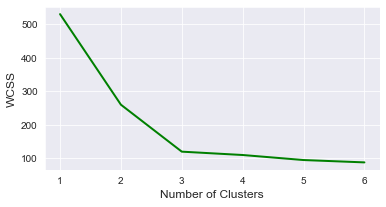

In [25]:
import pandas as pd

X = [1, 2, 3, 4, 5, 6]
Y = [530, 260, 120, 110, 95, 88]
df = pd.DataFrame({'X': X, 'Y': Y})
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
plt.figure(figsize=(6, 3))
sns.lineplot(x='X', y='Y', data=df, color='green', linewidth=2)
plt.xlabel('Number of Clusters', fontsize=12)
plt.ylabel('WCSS', fontsize=12)
plt.show()

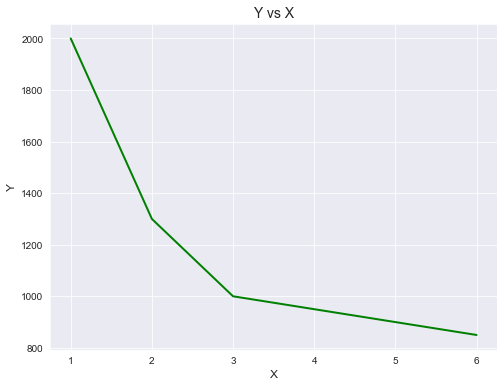

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
plt.figure(figsize=(8, 6))
sns.lineplot(x='X', y='Y', data=df, color='green', linewidth=2)
plt.title('Y vs X', fontsize=14)
plt.xlabel('X', fontsize=12)
plt.ylabel('Y', fontsize=12)
plt.show()